## Twitter Data Analysis Project

Twitter is a platform that contains a plethora of information. Not only can we scrape the tweets, but we get many different associated features with them, and we thought maybe they are valuable for doing data analysis. We were interested in modelling the distribution of retweet counts, and ideally predict the number of retweet counts given some other features. We later expanded this goal to include number of favourites as well. One example application of this could be that if you are a firm where public relations plays a huge role in your sales or day to day business, you might want to tweet well as it could bring a huge benefit to the market. The first step is to scrape data from twitter. We use the twitter API similar to how the yelp API worked for our first assignment.

### Scraping

In [1]:
import tweepy
from tweepy import OAuthHandler
from tweepy import Cursor
from unidecode import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib
from sklearn import mixture as mix

#functions for getting api

def read_key(path):
    with open(path, 'r') as f:
        api_key = f.read().replace('\n','')
    return api_key
def get_api():
    consumer_key = read_key("consumer_key.txt")
    consumer_secret = read_key("consumer_secret.txt")
    access_token = read_key("access_token.txt")
    access_secret = read_key("access_token_secret.txt")

    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
 
    return tweepy.API(auth, wait_on_rate_limit = True)

def read_words(path):
    words = {}
    with open(path, 'r') as f:
        for i in f.read().split("\n"):
            words[i] = 1
    return words

We use tweepy together with the API to scrape tweets. We get back tweet JSON objects that contain a lot of information. We only kept the features that seem to be somewhat related to retweet counts on an intuitive level, and we use a list of happy words and sad words to extract the number of such words in the tweets, and use store those as features as well. We only get the tweets from the Top 50 US Politics user list by richarda to narrow our scope a little bit. PR is probably very important for them too.

In [2]:
#source: https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/positive-words.txt
happy_words = read_words("positive-words.txt")
sad_words = read_words("negative-words.txt")

def count_words(lst, words):
    count = 0
    for i in lst:
        if i in words:
            count += 1
    return count
#scraping part
def get_tweet_info(api, users, num_items):
    #source: https://gist.github.com/nicolewhite/167828e51d8f2b6fad75
    cols = ["direct_reply", "year", "month_sin",
                                      "month_cos", "time_since_posted", "is_quote", "hashtags", 
                                       "user_mentions", "medias", "urls",
                                      "english", "favourites", "happy_words", "sad_words", "retweets"]
    counter = 0
    features = pd.DataFrame(columns = cols)
    users = Cursor(api.list_members, owner_screen_name = "richarda", slug = "top-50-us-politics").items()
    for user in users:
        
        tweet_count = 0
        for tweet in Cursor(api.user_timeline, screen_name = user.screen_name).items(num_items):
            direct_reply = 1 if tweet.in_reply_to_screen_name is not None else 0
            year = tweet.created_at.year
            month_sin = np.sin(2 * np.pi * tweet.created_at.month / 12)
            month_cos = np.cos(2 * np.pi * tweet.created_at.month / 12)
            time_since_posted = (datetime.datetime.now() - tweet.created_at + datetime.timedelta(hours = 4)).total_seconds()
            is_quote = 1 if tweet.is_quote_status else 0
            hashtags = len(tweet.entities.get('hashtags', None))
            med = tweet.entities.get('media', None)
            if med == None:
                medias = 0
            else:
                medias = len(med)
            us = tweet.entities.get('user_mentions', None)
            if us == None:
                user_mentions = 0
            else:
                user_mentions = len(us)
            ur = tweet.entities.get('urls', None)
            if ur == None:
                urls = 0
            else:
                urls = len(ur)
            english = 1 if tweet.lang == "en" else 0
            favourites = tweet.favorite_count
            retweets = tweet.retweet_count
            tweet_words = tweet.text.split()
            features.loc[counter] = [direct_reply,
                           year, month_sin, month_cos, time_since_posted, is_quote, hashtags,
                            user_mentions, medias, urls, english, favourites, count_words(tweet_words, happy_words),
                            count_words(tweet_words, sad_words), retweets]
            counter += 1

    return features
    
            

In [ ]:
users = ["top-50-us-politics"]

api = get_api()
df = get_tweet_info(api, users, 60)

In [23]:
df.to_csv("politicians_tweet_data.csv")

In [3]:
df = pd.read_csv("politicians_tweet_data.csv", index_col = 0)

In [3]:
df2 = pd.read_csv("politicians_tweet_data2.csv", index_col = 0)

### Modelling the Distribution

Next we plot histograms of the natural logarithms of the number of retweets. We chose to take the log of the data first before plotting them since we found the retweets span a very large range, from none to tens of thousands, or even millions. We used a trick that we think should preserve the distribution, but makes plotting easier, which is that we add one to the retweets before plotting them. If the number of bins is high enough, adding a constant to data will still give you the correct sense of what kind of distribution the data comes from, maybe it just makes it so that you can't directly model it. Since a lot of the retweet counts are zero, taking the log would be undefined, so we add one to make them come out to be zero. 

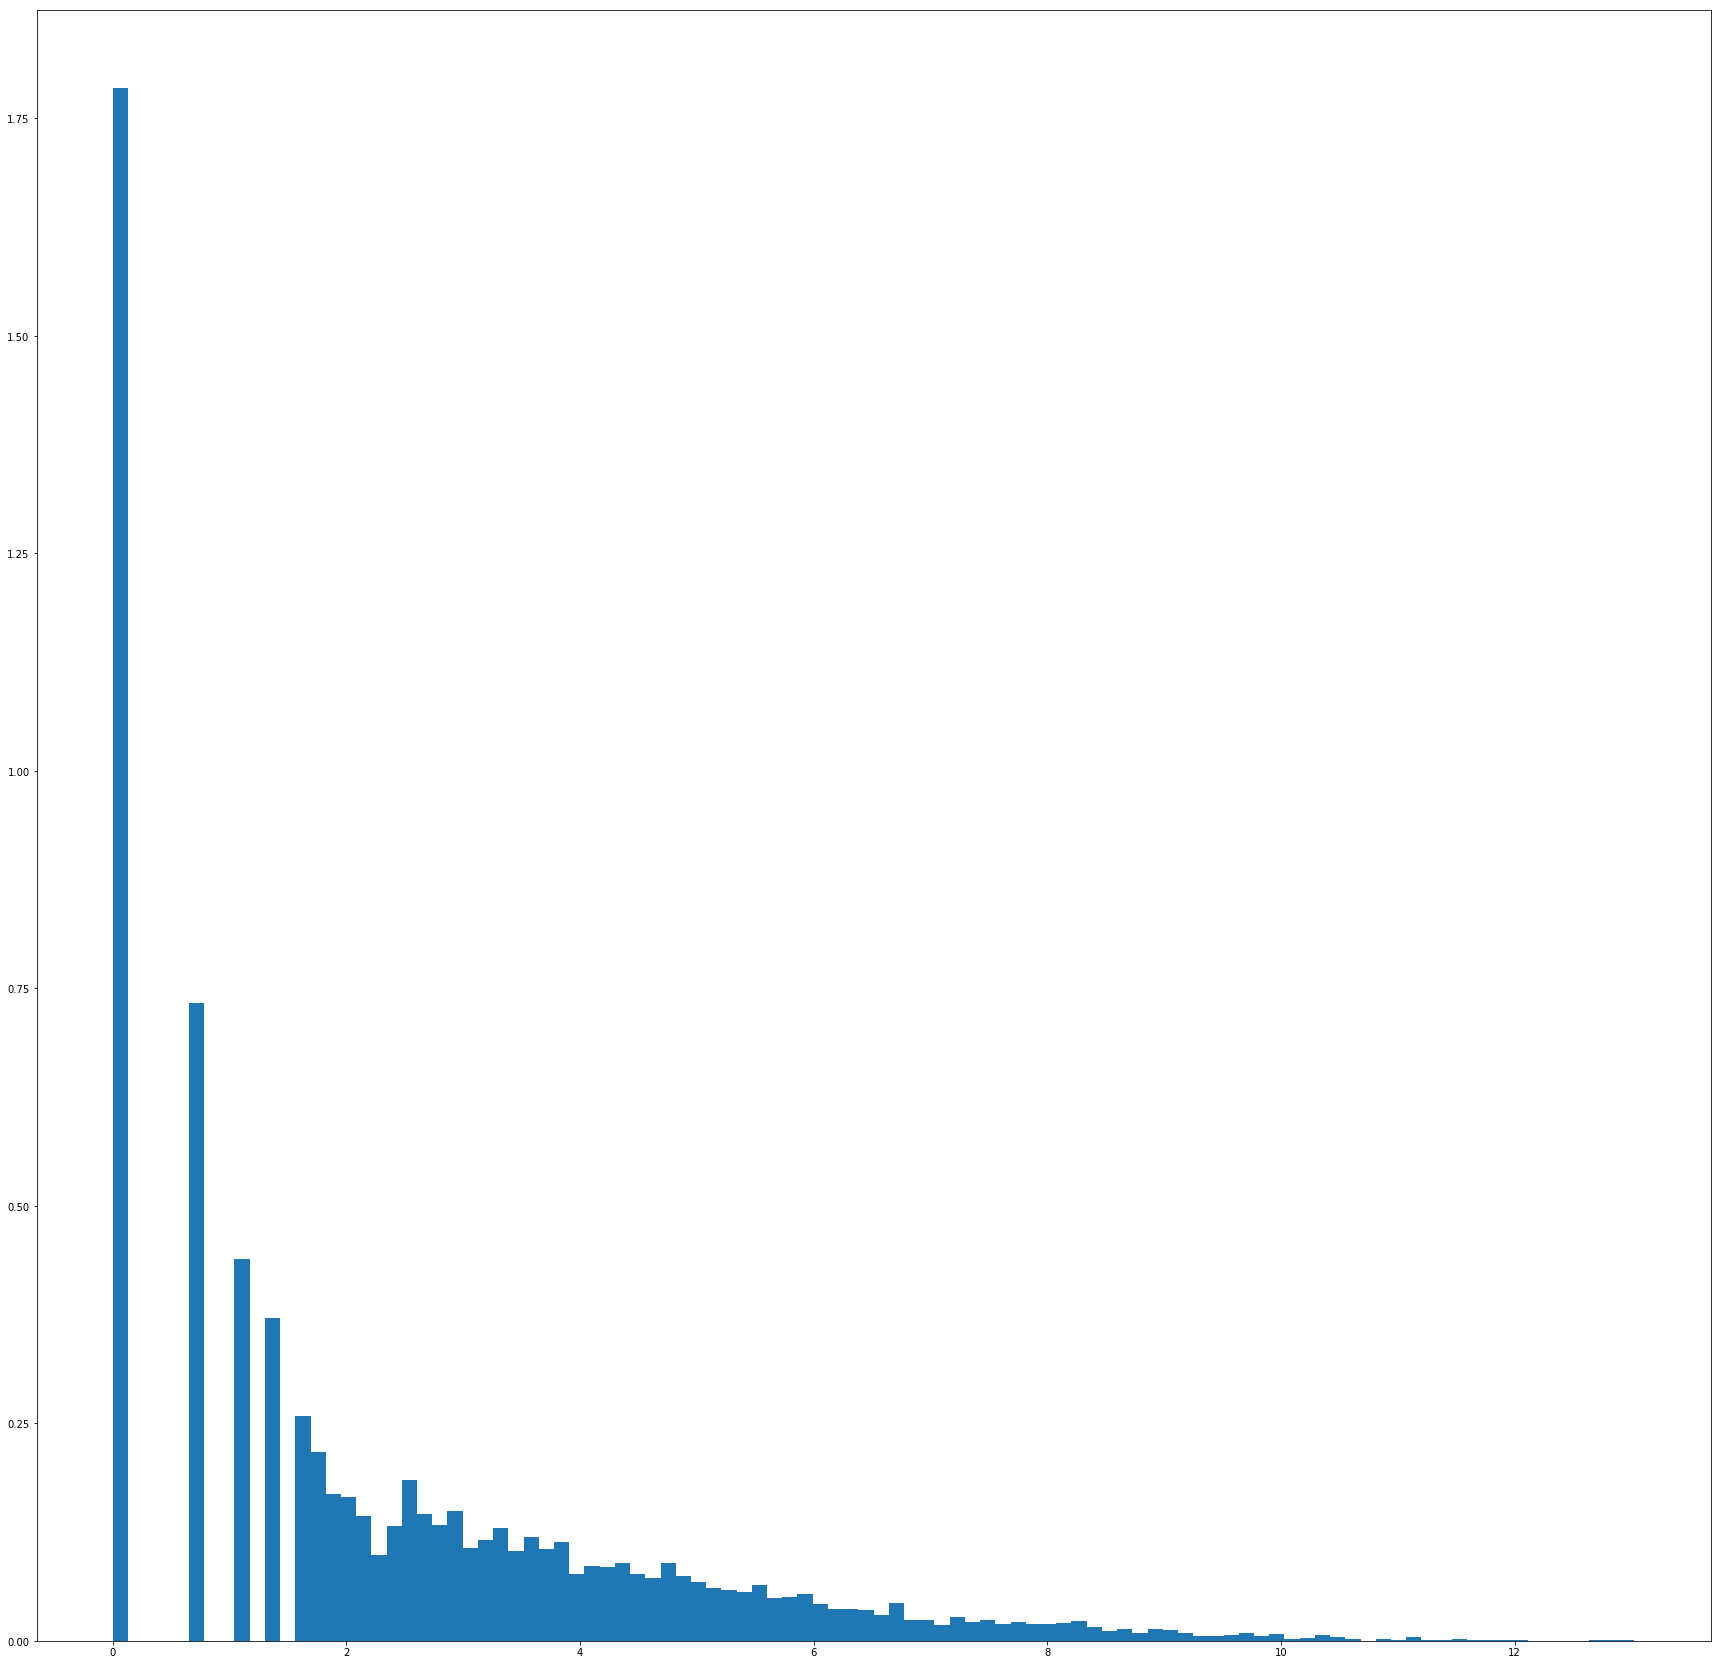

In [4]:
matplotlib.rcParams["figure.figsize"] = [30, 30]
#natural log of the retweets, +1 to prevent log(0) problem
log_retweets = np.log(df["retweets"] + 1)
plt.hist(log_retweets, bins = 100, density = True)
plt.show()

As you can see from the histogram, the distribution is clearly exponential-esque. It is not quite exponential since the starting frequency is way too high, and then after decreasing pretty rapidly it also slows down very quickly, so that it has heavy tails. A naive exponential distribution thus obviously wouldn't fit, and we need to try something more sophisticated. There is this distribution called a Lomax distribution that has a shape similar to this, but it is really hard to optimize for.
We decided to take out the first four values of log retweets and treat them separately, and model the rest as an exponential distribution.

In [32]:
n, bins, patches = ax.hist(log_retweets, bins = 100, density = True)

The following four lines of code are trying to determine what proportion of the entire sample space is each retweet count from 1 to 4.

In [42]:
print(len(log_retweets[log_retweets == 0]) / len(log_retweets))

0.2325648139290156


In [44]:
print((len(log_retweets[log_retweets <= 0.7]) - len(log_retweets[log_retweets <= 0.6]))/ len(log_retweets))

0.09547498325839472


In [45]:
print((len(log_retweets[log_retweets <= 1.1]) - len(log_retweets[log_retweets <= 1]))/ len(log_retweets))

0.05720845690232469


In [46]:
print((len(log_retweets[log_retweets <= 1.4]) - len(log_retweets[log_retweets <= 1.3]))/ len(log_retweets))

0.04831148952453841


In [48]:
probbs = [0.2325648139290156, 0.09547498325839472, 0.05720845690232469, 0.04831148952453841]

The following function samples from a custom defined distribution. The distribution is: Flip a biased coin with the probabilities being equal to the proportion of samples that have retweets from 1 to 4, and 1 minus this probability. If it lands on heads, then randomly choose one of 1 to 4 based on their respective proportions. This is trying to approximate the part of the sample distribution that is way higher than an exponential distribution by treating them separately. If the coin lands on tails, then sample from an exponential distribution that is fit to the rest of the log retweets.
Our goal is to see whether after plotting the histogram of the sampled data, it looks like the histogram of the original sample. This is our way of evaluating the fitted distribution.

In [60]:
def sample_from_mixed_dist(choices, probs, lam, scale, min_minus, rangee, prob):
    
    if np.random.choice(a = [0, 1], p = [prob, 1 - prob]) < 1:
        return np.random.choice(a = choices, p = probs)
    else:
        #the samples are from an actual distribution, but we need the retweet
        #counts to be bigger than 4 and stretched back, so apply the scaling
        #backwards
        return np.random.exponential(scale = 1 / lam) * rangee / scale + min_minus


Here we try to fit a Gaussian Mixture Model to the data. As you can see, it works pretty poorly. We think it would be the same even if we increase the number fo Gaussians. We believe it is because the data is just not Gaussian, even if a mixture of Gaussians can fit any data, and that the first part is too high so that it needs a very narrow and tall Gaussian there which means it would also drop down really fast. We believe that our data is exponential in nature, and if a mixture of Gaussians fit the data well because log retweets is inherently discrete and so some x values have no probability and some have very high(namely the x values that correspond to the natural log of some integer), it is a bad distribution even if it fits our data well.

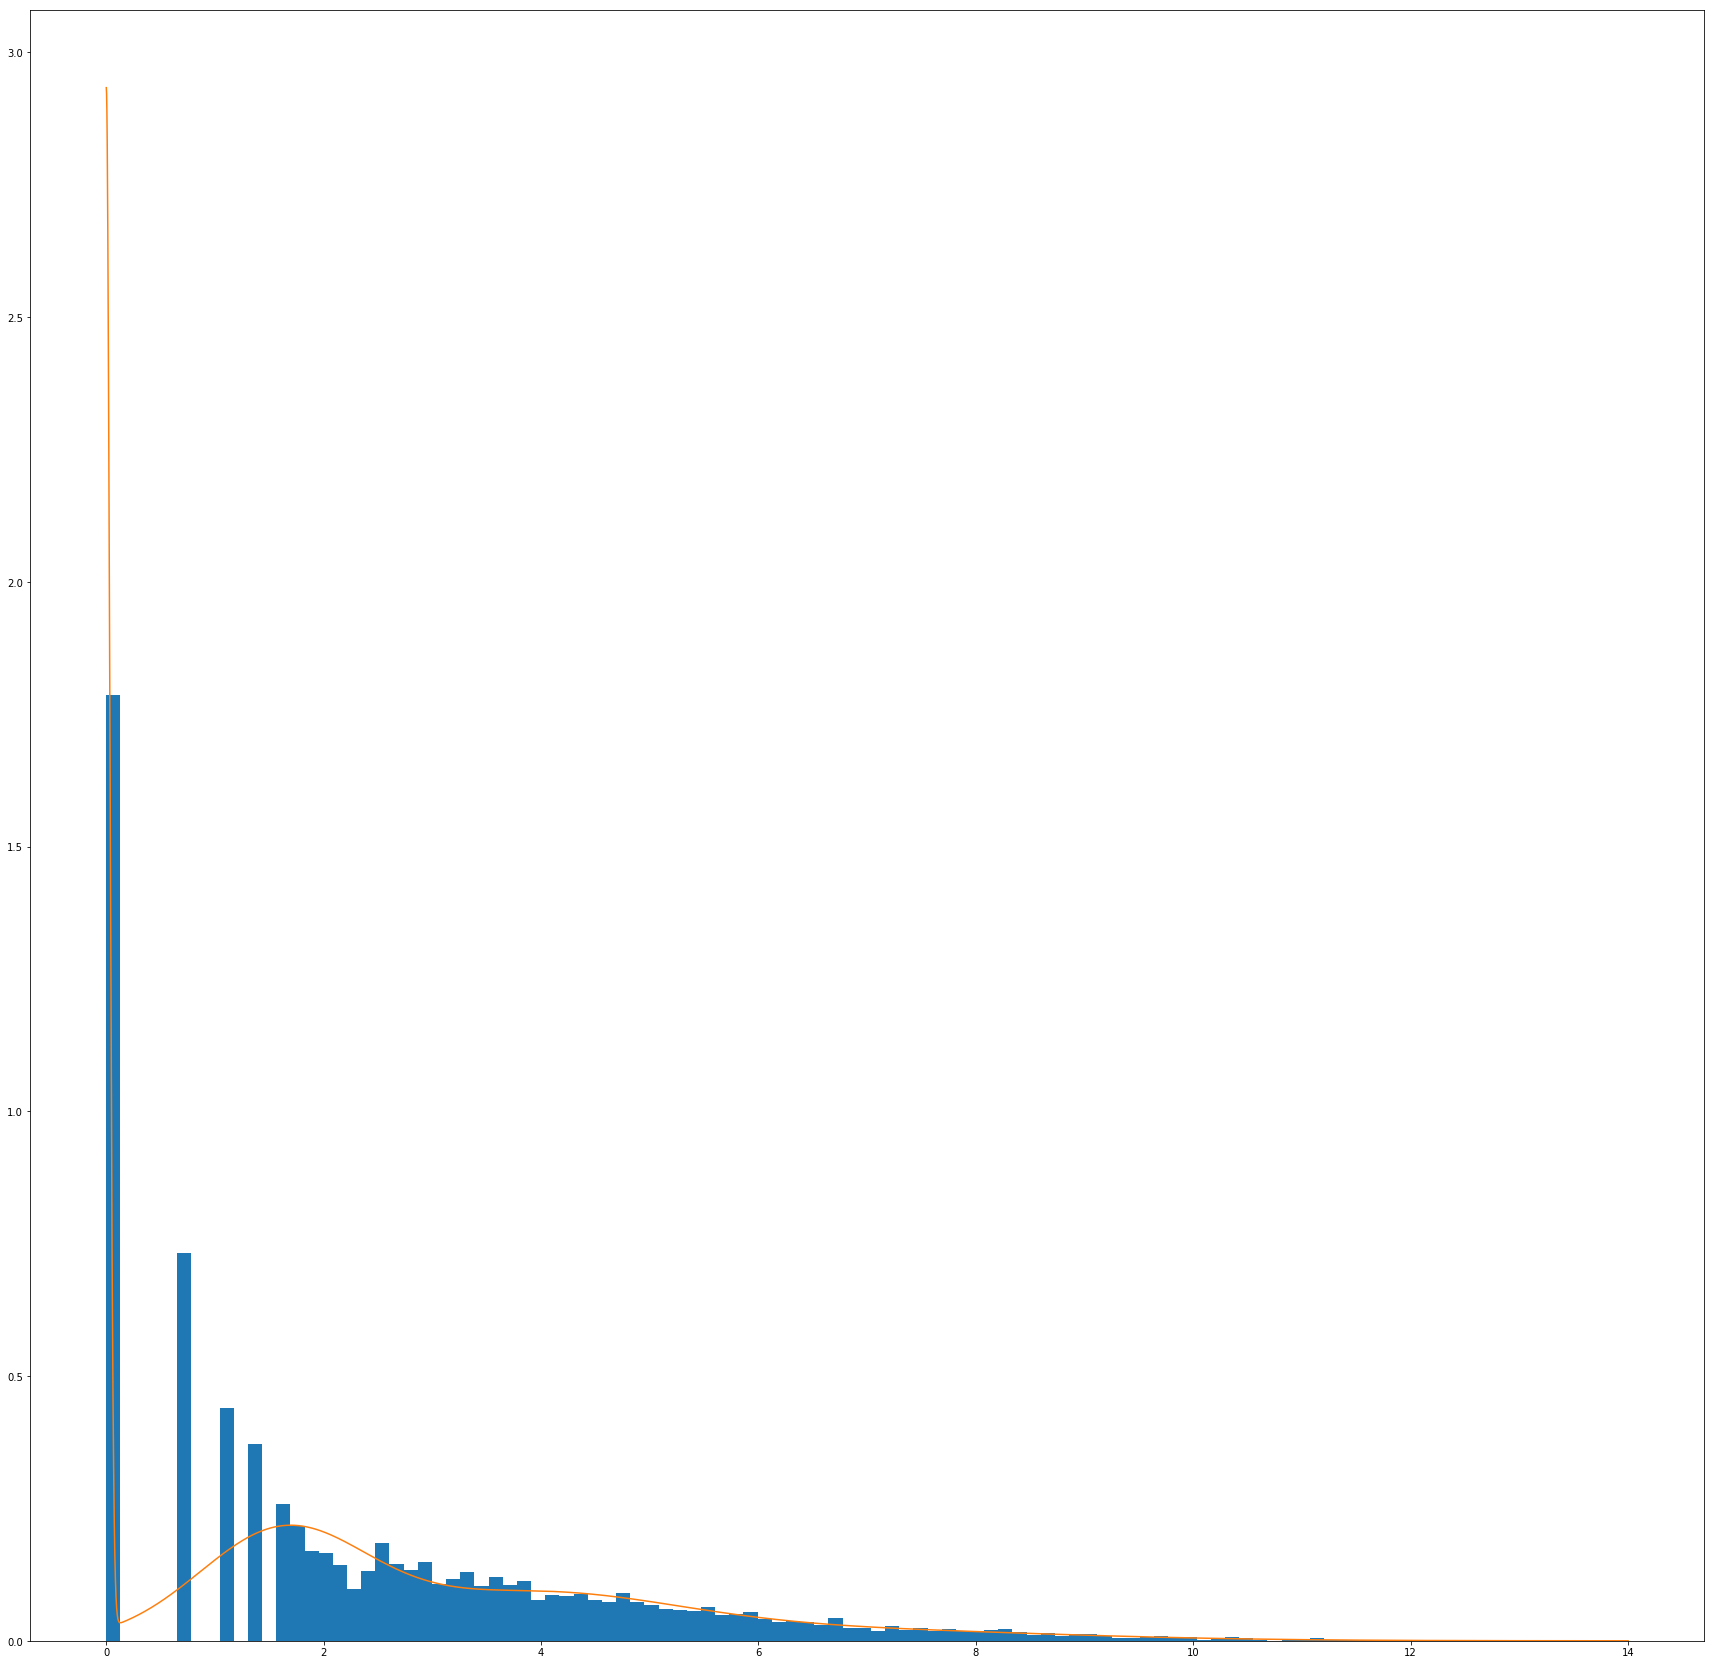

In [9]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 1)
ax1.hist(log_retweets, bins = 100, density = True)
gmm = mix.GMM(n_components = 4, covariance_type = 'full')
gmm = gmm.fit(np.expand_dims(log_retweets, 1))
gmm_x = np.linspace(0, 14, 5000)
gmm_y = np.exp(gmm.score(gmm_x.reshape(-1, 1)))
ax1.plot(gmm_x, gmm_y)

In [ ]:
#Code for computing the MLE and plotting an exponential distribution
import math
def exp_mle(retw):
    return sum(retw) / len(retw)
def plot_exp(lam, x, ax):
    ax.plot(x, [lam * math.exp(-lam * t) for t in x])
    plt.show()

In [ ]:
#get only the retweets that are bigger than 4, and scale them so that
#they can be better fit by an exponential distribution
log_retweets5 = log_retweets[log_retweets > 1.4]
min_log2 = min(log_retweets5)
max_log2 = max(log_retweets5)
log_retweets5 = (log_retweets5 - min_log2) * 4.5 / (max_log2 - min_log2)

In [61]:
mle_lam = exp_mle(log_retweets5)
choices = [0, np.log(2), np.log(3), np.log(4)]
prob_sum = sum(probbs)
norm_probs = [i / prob_sum for i in probbs]
samples = [sample_from_mixed_dist(choices, norm_probs, mle_lam, 4.5, min_log2, (max_log2 - min_log2), prob_sum) for i in range(len(log_retweets2))]

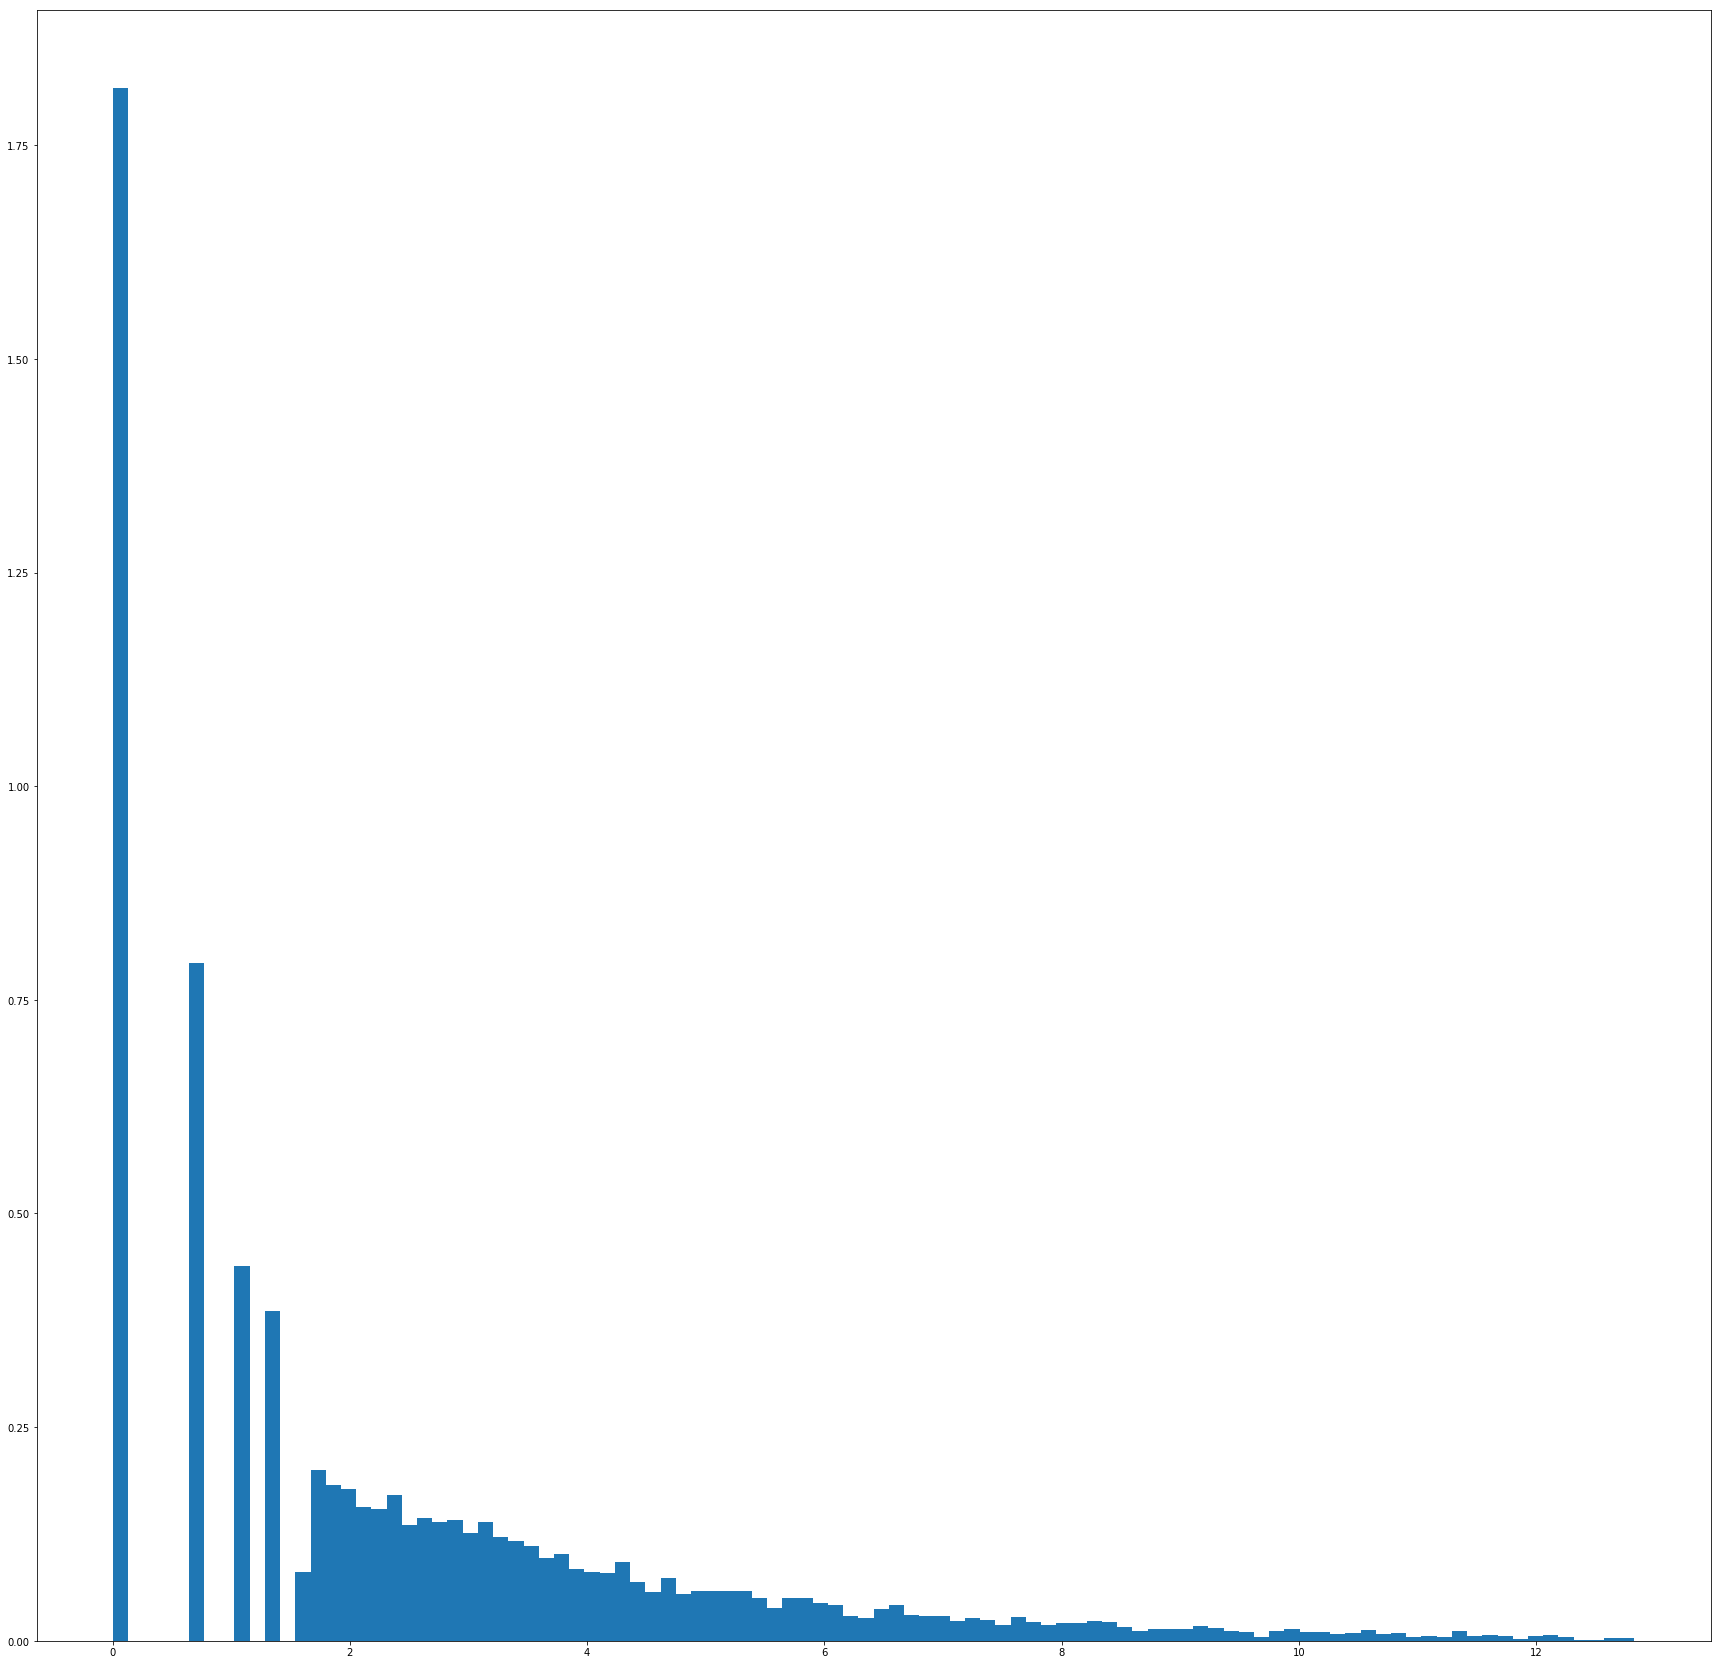

In [72]:
plt.hist(samples, bins = binss, density = True)
plt.show()

We evaluate the samples we get by summing the differences of the counts of each bin between the new samples and the original samples, and divide by 2 in the end, since if some data points don't appear in some bin, they will appear in some other bin, thereby double counting the errors.

In [74]:
def diff_prob(samples, x):
    n, bins, patches = plt.hist(samples, bins = binss)
    n2, bins2, patches2 = plt.hist(x, bins = binss)
    print(sum(abs(n2 - n)) / 2)
diff_prob(samples, log_retweets2)

945.0


The result is that we get 945 out of a little more than 10000 wrong.

### Attempted Classification

Next we try to see whether we can predict whether a tweet gets retweeted or not based on how many sentiment words it has. We try to see if there is any signal in the data that shows a trend that either having more sentiment words results in more retweets or fewer.

In [27]:
df["total_words"] = df["happy_words"] + df["sad_words"]
df["has_retweet"] = df["retweets"].map(lambda x: min(1, x))
print(df.groupby(["total_words", "has_retweet"]).size())
print(df.groupby(["happy_words", "has_retweet"]).size())
print(df.groupby(["sad_words", "has_retweet"]).size())

total_words  has_retweet
0            0              1527
             1              4303
1            0               669
             1              2501
2            0               182
             1               940
3            0                48
             1               238
4            0                 5
             1                31
5            1                 9
dtype: int64
happy_words  has_retweet
0            0              1841
             1              5762
1            0               491
             1              1802
2            0                84
             1               393
3            0                10
             1                61
4            0                 5
             1                 2
5            1                 2
dtype: int64
sad_words  has_retweet
0          0              2013
           1              6026
1          0               354
           1              1585
2          0                58
           1        

As you can see from the print out, there is no correlation at all between the number of sentiment words and whether a tweet gets retweeted or not. It seems very uniform: a tweet can be retweeted regardless of the number of sentiment words.
We think that this classification task may not be a good idea because it assigns a special meaning to the boundary of 0 retweet and 1 retweet, and that has to intuitively be a cutoff point for a classifier to work. But in fact, it's not. The difference between 1 retweet and 1000 retweets should be more significant than that of 0 and 1 retweet, and yet we put them in the same class. So we determined that this classification task is pointless, and is not doable anyway, and we decided to focus on classifying the first tenth percentile and the last tenth percentile given training data in these regions, similarly as in the lecture, as we think this is more meaningful and might be doable.

In [27]:
df3 = pd.read_csv("politician_data_fullset.csv", index_col = 0, low_memory = False)
df3.drop(df3.columns[list(range(14, len(df3.columns)))], axis = 1, inplace=True)

In [ ]:
df3["retweets"] = pd.to_numeric(df3["retweets"], errors = "coerce")
df3.dropna(inplace = True)

In [29]:
df3.sort_values(by=["retweets"], ascending=False, inplace=True)
print(df3.head())

       direct_reply    year  month_sin  month_cos  time_since_posted  \
53002           0.0  2017.0  -0.866025  -0.500000       2.258562e+07   
19124           0.0  2017.0  -0.500000   0.866025       1.397182e+07   
18945           0.0  2018.0   0.866025   0.500000       5.861774e+06   
34155           0.0  2018.0   0.866025   0.500000       6.443694e+06   
34324           0.0  2018.0   0.500000   0.866025       9.136650e+06   

       is_quote  hashtags  user_mentions  medias  urls  english  favourites  \
53002       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
19124       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
18945       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
34155       0.0       0.0            1.0     0.0   0.0      1.0         0.0   
34324       0.0       0.0            1.0     0.0   0.0      1.0         0.0   

                                             tweet_words   retweets  
53002  RT @BarackObama

We want to see whether we can guess if a retweet is from the first or last tenth percentile, and if we can do it a classifier possibly can too. So we took the code from lecture and modified it a little bit to play our game

In [37]:
def ranking_game2():
    it1 = np.random.randint(len(df3)//10)
    it2 = np.random.randint(len(df3)//10) + 9*len(df3)//10
    if np.random.rand() < 0.5:
        it1,it2 = (it2,it1)
    
    print(df3.iloc[it1]["tweet_words"])
    print("-------")
    print(df3.iloc[it2]["tweet_words"])
    print("-------")
    
    guess = int(input("Which tweet has more retweets (1/2)?"))
    
    print("True Rating: {} / {}".format(df3.iloc[it1]["retweets"], df3.iloc[it2]["retweets"]))
    correct = ((guess == 1) and (it1 < it2)) or ((guess == 2) and (it1 > it2))
    print("{}".format("Correct!" if correct else "Incorrect!"))

In [47]:
ranking_game2()

I had a dream last night that someone cut all my hair off while I was sleeping 😱 What does this mean!
-------
There are 118 House Republicans in seats that went for Trump by less than this district. Democrats need to win 24 s… https://t.co/6sZU4758x6
-------
Which tweet has more retweets (1/2)?2
True Rating: 0.0 / 904.0
Correct!


We did pretty well in this. We think tfidf features would work because we noticed some recurring keywords among popular tweets.

### Further Information

1. How to scrape Twitter Data: https://knightlab.northwestern.edu/2014/03/15/a-beginners-guide-to-collecting-twitter-data-and-a-bit-of-web-scraping/
2. Lomax distribution: https://en.wikipedia.org/wiki/Lomax_distribution
3. Exponential distribution: https://en.wikipedia.org/wiki/Exponential_distribution
4. Twitter sentiment analysis: https://www.csc2.ncsu.edu/faculty/healey/tweet_viz/tweet_app/